# Analysis on Starbucks & McDonald's Menu Items

Author: Michelle Kwan

Course Project, UC Irvine, Math 10, F22

## Introduction

For my project, I will attempt to do a comparison between Starbucks and McDonald's menu items to determine which food items at each location are considered "unhealthy" in terms of calories, fat, and carbohydrates. For drinks, the "unhealthiest" would be predicting a correlation between nutrition factors, primarily sugars and calories. In the end, I will also explore a Decision Tree Classifier to see if it can predict which store a particular food item is from. 

## Cleaning Data

In order to do a comparison between the menu items from Starbucks and McDonald's, I recognized that I would have to use the datasets that I imported from Kaggle, which are labeled as `df_mcd`,`df_sdrink`,and `dfsfood`, to create separate datasets that correspond with each location and type of menu item. I would then have to combine these new datasets to create 2 final datasets for me to work with: one for food items and one for drink items from both locations. 


In [1]:
import pandas as pd
from pandas.api.types import is_numeric_dtype

In [2]:
df_mcd = pd.read_csv("mcdonalds.csv")
df_sfood = pd.read_csv("starbucks_food.csv")
df_sdrink = pd.read_csv("starbucks_drink.csv")

In [3]:
df_mcdfood = df_mcd[~df_mcd["Category"].isin(["Coffee & Tea","Smoothies & Shakes","Beverages"])]

In [4]:
df_mcdfood = df_mcdfood[["Item", "Calories", "Total Fat", "Carbohydrates", "Dietary Fiber", "Protein"]].copy()

In [5]:
df_mcdfood.insert(0, "Store", "McDonald's")

In [6]:
df_mcddrink = df_mcd[df_mcd["Category"].isin(["Coffee & Tea","Smoothies & Shakes","Beverages"])]

In [7]:
df_mcddrink = df_mcddrink[df_mcddrink["Serving Size"].str.contains("12 fl oz cup|16 fl oz cup")]

In [8]:
df_mcddrink["Serving Size"] = df_mcddrink["Serving Size"].apply(lambda x: x.strip("fl oz cup"))

In [9]:
df_mcddrink = df_mcddrink.iloc[:, [1,2,3,14,18,19,20,21,22,23]].copy()
df_mcddrink.insert(0, "Store", "McDonald's")

From the `df_mcd` dataset, I created 2 new datasets: `df_mcdfood` and `df_mcddrink`. From viewing the columns of `df_mcd`,`df_sdrink`,and `dfsfood`, I selected columns that appear in both the Starbucks and McDonald's datasets. I also noticed that the sizes of drinks offered at both locations are only 12 oz and 16 oz drinks, so I only selected the rows that contained these values. These 2 new datasets now serve as a template for the way I want the Starbucks datasets to look like. 

In [10]:
df_sfood.insert(0,"Store", "Starbucks")

In [11]:
df_sfood["Total Fat"] = df_sfood["Total Fat"].astype(int)

In [12]:
df_sdrink = df_sdrink[df_sdrink["Beverage_prep"].str.contains("Tall|Grande")]

In [13]:
df_sdrink["Beverage_prep"] = df_sdrink["Beverage_prep"].apply(lambda x: "12" if "Tall" in x else "16")

In [14]:
df_sdrink = df_sdrink.iloc[:, [1,2,3,8,11,12,13,14,15,16]].copy()

In [15]:
df_sdrink.insert(0,"Store", "Starbucks")

In [16]:
df_sdrink.columns=df_mcddrink.columns.values

In [17]:
df_sdrink["Vitamin A (% Daily Value)"] = df_sdrink["Vitamin A (% Daily Value)"].str.strip("%")
df_sdrink["Vitamin C (% Daily Value)"] = df_sdrink["Vitamin C (% Daily Value)"].str.strip("%")
df_sdrink["Calcium (% Daily Value)"] = df_sdrink["Calcium (% Daily Value)"].str.strip("%")
df_sdrink["Iron (% Daily Value)"] = df_sdrink["Iron (% Daily Value)"].str.strip("%")

When attempting to merge the individual datasets that I created to create the 2 final ones, I ran into a lot of errors, such as that I "could not convert string to float." After examining each individual dataset, I realized that in `df_sdrink`, the values in the last 4 columns were objects while in `df_mcddrink`, the values were integers. It is inefficient to strip the percentage symbol (%) from each column individually, but after many attempts, I could still not figure out how to use list comprehension to do it efficiently. 

In [18]:
df_food = pd.concat((df_mcdfood, df_sfood))

In [19]:
df_food.head()

,Store,Item,Calories,Total Fat,Carbohydrates,Dietary Fiber,Protein
0,McDonald's,Egg McMuffin,300,13.0,31,4,17
1,McDonald's,Egg White Delight,250,8.0,30,4,18
2,McDonald's,Sausage McMuffin,370,23.0,29,4,14
3,McDonald's,Sausage McMuffin with Egg,450,28.0,30,4,21
4,McDonald's,Sausage McMuffin with Egg Whites,400,23.0,30,4,21


In [20]:
df_drink = pd.concat((df_mcddrink, df_sdrink))

In [21]:
cols = ["Serving Size", "Vitamin A (% Daily Value)","Vitamin C (% Daily Value)","Calcium (% Daily Value)","Iron (% Daily Value)"]

In [22]:
df_drink[cols] = df_drink[cols].apply(pd.to_numeric)

In [23]:
df_drink.head()

,Store,Item,Serving Size,Calories,Carbohydrates,Sugars,Protein,Vitamin A (% Daily Value),Vitamin C (% Daily Value),Calcium (% Daily Value),Iron (% Daily Value)
110,McDonald's,Coca-Cola Classic (Small),16,140,39,39,0.0,0,0,0,0.0
113,McDonald's,Coca-Cola Classic (Child),12,100,28,28,0.0,0,0,0,0.0
114,McDonald's,Diet Coke (Small),16,0,0,0,0.0,0,0,0,0.0
117,McDonald's,Diet Coke (Child),12,0,0,0,0.0,0,0,0,0.0
118,McDonald's,Dr Pepper (Small),16,140,37,35,0.0,0,0,0,0.0


To create the final datasets for food and drinks, I used the `pd.concat` method because I ran into errors when trying to use `merge`. This suggests that I probably still have errors within the individual dataset, which will also affect the final dataset created.  

## K-means Clustering on Food Items
In this portion of my project, I performed K-means Clustering to group the food items by "calories" and examined the relationship between "total fat" and "carbohydrates."

In [24]:
import altair as alt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

Before I used the Elbow method to determine how many clusters I needed for K-means clustering, I played around with different numbers and made some observations. One of the observations that I made was that the 40 piece Chicken McNuggets was an outlier so it made the scaling of the graph weird. Therefore, I removed it from the dataset. 

In [25]:
df_food.drop([82], inplace=True)

As all the columns need to be numeric in order to perform K-means clustering, I used a list comprehension to get all the numeric columns. 

In [26]:
a = [x for x in df_food.columns if is_numeric_dtype(df_food[x])]

I also recognized that because the units for the columns are different, such as how calories is measured in "cal" while total fat is measured in "grams," I needed to use `StandardScaler` to rescale. 

The configuration of the following code and Seaborn plot was adapted from [Stack Abuse](https://stackabuse.com/k-means-clustering-with-the-elbow-method/). The Elbow method is used to determine the best amount of clusters needed for K-means clustering. This can be visually found in the plot by the lowest point on the line. 

For the plot below, it looks like the lowest point is when `x=6`, so I used 6 for `n_clusters` when running the K-means cluster algorithm. 


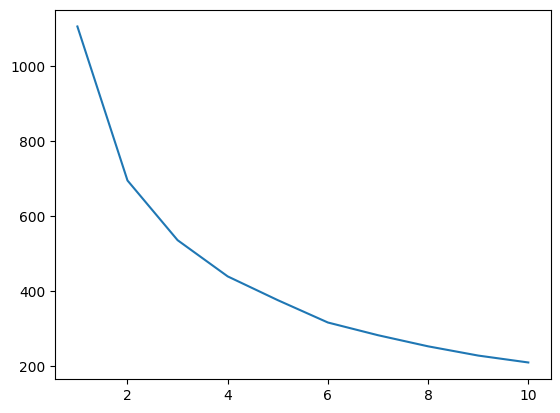

In [27]:
ss = StandardScaler()
scaled_f = ss.fit_transform(df_food[a])
food = []
for i in range(1,11):
    clustering1 = KMeans(n_clusters=i, init="k-means++")
    clustering1.fit(scaled_f)
    food.append(clustering1.inertia_)

ks = range(1,11)
sns.lineplot(x = ks, y = food);

In [28]:
kmeansf = KMeans(n_clusters=6)

In [29]:
kmeansf.fit(scaled_f)

KMeans(n_clusters=6)

In [30]:
df_food2=df_food.copy()

In [31]:
df_food2["cluster"] = kmeansf.predict(scaled_f)

In [32]:
sel = alt.selection_single(fields=["cluster"], empty="none")

food = alt.Chart(df_food2).mark_circle().encode(
    x = "Total Fat",
    y = "Carbohydrates",
    tooltip = ["Store", "Item", "Calories"],
    size = alt.condition(sel, alt.value(80),alt.value(20)),
    color = alt.Color("cluster:N"),
    opacity = alt.condition(sel, alt.value(1), alt.value(0.4))
    
).add_selection(
    sel
).properties(
    title = "Clustering by Calories"
)

food

alt.Chart(...)

In [33]:
df_food2["cluster"].value_counts()

1    75
0    60
3    49
5    21
4    12
2     4
Name: cluster, dtype: int64

From observation, the data is clustered by food items that have similar "Calories" in terms of the positive relationship between "Total Fat" and "Carbohydrates." 

In comparison to McDonald's and Starbucks food items, McDonald's has the most food items that generally have a high number of "Calories," "Total Fat," and "Carbohydrates." However, this makes sense because McDonald's serves an assortment of food items while Starbucks mainly caters and provides drinks. 

## Linear Regression on Drinks
In this portion of my project, I performed Linear Regression with multiple input variables on the drinks dataset to see how strong the relationship is between certain independent variables and "calories."

In [34]:
from sklearn.linear_model import LinearRegression

In [35]:
b = [x for x in df_drink.columns if is_numeric_dtype(df_drink[x])]

In [36]:
b.remove("Serving Size")

In [37]:
b.remove("Calories")

Similar to the food dataset, the units in each column of the drink dataset are different. Therefore I have to use `StandardScaler` to rescale the input features before performing Linear Regression. 

In [38]:
df_drink2 = df_drink.copy()

In [39]:
scaler = StandardScaler()

In [40]:
scaler.fit(df_drink[b])

StandardScaler()

In [41]:
df_drink2[b] = scaler.transform(df_drink[b])

After scaling my data, I performed Linear Regression. 

In [42]:
reg = LinearRegression()

In [43]:
reg.fit(df_drink2[b],df_drink2["Calories"])

LinearRegression()

In [44]:
reg.coef_

array([-23.34527678, 127.04112742,  34.7671284 ,  -0.56018751,
        -5.53703722,   8.16543777,   1.64037784])

In [45]:
reg.feature_names_in_

array(['Carbohydrates', 'Sugars', 'Protein', 'Vitamin A (% Daily Value)',
       'Vitamin C (% Daily Value)', 'Calcium (% Daily Value)',
       'Iron (% Daily Value)'], dtype=object)

The scaled "Sugars" coefficient has the largest value, which means that out of the 7 features, it is the most important with respect to "Calories."

In [46]:
df_drink2["pred"] = reg.predict(df_drink2[b])

In [47]:
c1 = alt.Chart(df_drink2).mark_circle().encode(
    x = "Sugars",
    y = "pred"
)
c1

alt.Chart(...)

In [48]:
c2 = alt.Chart(df_drink2).mark_line().encode(
    x = "Sugars",
    y = "Calories", 
    tooltip = b
).properties(
    title = "Relationship between Sugars and Calories"
)
c1+c2

alt.LayerChart(...)

The predicted values do not necessarily look linear due to the fact that the points rely on 7 values. I'm not exactly sure why but in my graph, there are negative values plotted for "Sugars" and the predicted "Calories." This can be because I rescaled my data when I might have not needed to. 

Looking at the chart and noticing a positive slope, we are able to conclude that the more "sugars" there are in a drink, it leads to more "calories." I believe that this conclusion makes sense because in both locations, there are drink options that have whipped cream, syrups, or extra added ingredients that increase the sugar count. 

## Classification on Food Items based on Stores
In this portion of my project, I used a Decision Tree Classifier to see if it could predict the store for a food item with its contents of "calories," "total fat," "carbohydrates," "dietary fiber," and "protein."



In [49]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [50]:
df_food3 = df_food.copy()

In [51]:
df_food3 = df_food.drop(["Item"], axis=1)

I dropped the "items" column from the food dataset because we don't need categorical variables. I used the `a` that was defined earlier when K-means clustering was performed on the food items since it only contains numeric values. 

In [52]:
X = df_food3[a]
y = df_food3["Store"]

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

While any values can be chosen for `max_leaf_nodes` and `max_depth`, I chose these values because they provided me with one of the highest scores on the test set.  

In [54]:
clf = DecisionTreeClassifier(max_leaf_nodes=10, max_depth=6)

In [55]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, max_leaf_nodes=10)

In [56]:
clf.score(X_train,y_train)

0.8121212121212121

This score on the training set means there is an accuracy of 81.21% on predicting whether a food item is from Starbucks or McDonald's. 

In [57]:
clf.score(X_test, y_test)

0.7142857142857143

As the accuracy of the training set is not within 5% of the accuracy on the test set, this means that the tree is drastically overfitting the data. However, even after playing around with adding values for `train_size`, and adjusting the `max_depth` and `max_leaf_nodes` values, I was unable to consistently get a higher accuracy score for the training set or the test set. 

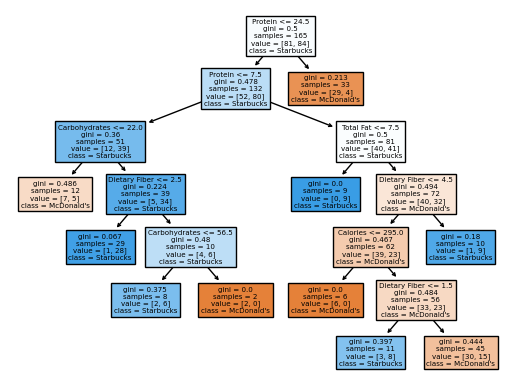

In [58]:
fig = plt.figure()
tree = plot_tree(clf, 
                   feature_names=clf.feature_names_in_,
                   class_names=clf.classes_,
                   filled=True)

## Summary 

From the datasets that I downloaded from Kaggle, I created 2 datasets that combined Starbucks and McDonald's food and drink items respectively. For the food dataset, I used K-means clustering to group the items by calories. With the clustering, I found a positive relationship between total fat and carbohydrates. Additionally, I used the food dataset and a DecisionTreeClassifier to see if it could predict whether a certain item is from Starbucks or McDonald's. The accuracy of my classifier is only 81%, but shows that I am most likely overfitting my data. For the drink dataset, I performed Linear Regression with multiple input variables and rescaled features. From this, I learned that sugars is the most important of out of the 7 features with respect to calories, so there is a positive relationship between the two. 

## References

Your code above should include references.  Here is some additional space for references.

* What is the source of your dataset(s)?
https://www.kaggle.com/datasets/starbucks/starbucks-menu?select=starbucks_drinkMenu_expanded.csv

https://www.kaggle.com/datasets/mcdonalds/nutrition-facts

* List any other references that you found helpful.
https://stackabuse.com/k-means-clustering-with-the-elbow-method/
https://stackabuse.com/k-means-clustering-with-scikit-learn/


## Submission

Using the Share button at the top right, **enable Comment privileges** for anyone with a link to the project. Then submit that link on Canvas.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ebce4e71-9da1-44e6-b6a8-cc6651c9d3d3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>